In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
import gpplot as gpp
from rs3.seq import predict_seq
import random
from zipfile import ZipFile
import scipy
from statsmodels.stats.multitest import multipletests
gpp.set_aesthetics(context = 'paper')

In [5]:
#reads
reads_df = pd.read_excel('../../Data/externalData/horlbeck_etal_2016_hCRISPRiv2.xlsx')
reads_df

,sgID,gene,transcript,protospacer sequence,selection rank,predicted score,empirical score,off-target stringency,CRISPRi-v2.1 predicted score,Sublibrary,Sublibrary half
0,[gene_strandtargeted_PAMcoordinate.sgRNAlength...,"[gene targeted by the sgRNA, or ""negative_cont...",[TSS targeted by the sgRNA; see Table S2],[protospacer sequence; 5'G is included whether...,"[for each gene/transcript pair, the order in w...",[predicted score by CRISPRi-v2 (not 2.1) algor...,"[empirical activity score, where available]",[stringency level at which sgRNA passed thresh...,[predicted score by CRISPRi-v2.1 algorithm],h1-Kinases/Phosphatases/Drug Targets,[Top5 sgRNAs per TSS or Supp5 sgRNAs to create...
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,h2-Cancer/Apoptosis,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,h3-Stress/Proteostasis,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,h4-Mitochondria/Trafficking/Motility,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,h5-Gene Expression,NaN
...,...,...,...,...,...,...,...,...,...,...,...
209073,non-targeting_03785,negative_control,na,GCTACTCCGCCCCGCGGGAG,NaN,NaN,NaN,0,NaN,h7,Supp5
209074,non-targeting_03786,negative_control,na,GTGGCCGTTCATGGGACCGG,NaN,NaN,NaN,0,NaN,h7,Supp5
209075,non-targeting_03787,negative_control,na,GAACTCTGTAGAAGGGACCG,NaN,NaN,NaN,0,NaN,h7,Supp5
209076,non-targeting_03788,negative_control,na,GCTCGACAGCGACTGAAGAG,NaN,NaN,NaN,0,NaN,h7,Supp5


In [3]:
#read in Set B reads, concatenate Set A and Set B
reads_B = pd.read_excel('../../Data/externalData/sanson_et_al_2018_dolcetto_screens.xlsx',sheet_name = 1)
reads_B = reads_B.drop([0],axis=0).reset_index(drop=True)
reads_B.columns = reads_A.columns
reads_df = pd.concat([reads_A,reads_B],axis=0).reset_index(drop=True)
reads_df

/opt/miniconda3/envs/crispri/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,sgRNA Sequence,pDNA,HT29_RepA,HT29_RepB,HT29_RepC,A375_RepA,A375_RepB,A375_RepC
0,AAAAAAAAAATACTGAGAGA,503,264,231,275,483,608,337
1,AAAAAAAAGAGGAGGGACGG,821,184,255,115,181,250,123
2,AAAAAAAATTTCCTAGCGTG,304,61,148,207,213,319,247
3,AAAAAAACCAGCCTAGCTCG,457,246,220,199,558,505,314
4,AAAAAAACTGTCCCGCAACC,1108,581,305,593,1214,975,688
...,...,...,...,...,...,...,...,...
114056,TTTGTTGACACATGTGGTGC,888,967,1514,780,1035,973,742
114057,TTTGTTGTATAGCTGCAGAT,866,996,916,573,1118,1105,1245
114058,TTTGTTGTCTATGCCTTTAG,919,867,1093,900,1594,960,977
114059,TTTGTTTACTTGGCGAGACT,826,728,977,822,1131,694,667


In [54]:
#read in gene annotations (using NCBI annotations because DepMap essential/nonessential lists use NCBI annotations)
annotations_df_A = pd.read_table("../../Data/externalData/CP0055_GRCh38_NCBI_CRISPRi_strict_gene_20240130.chip")
annotations_df_A = annotations_df_A.rename(columns = {'Barcode Sequence':'sgRNA Sequence'})

annotations_df_B = pd.read_table("../../Data/externalData/CP0056_GRCh38_NCBI_CRISPRi_strict_gene_20240130.chip")
annotations_df_B = annotations_df_B.rename(columns = {'Barcode Sequence':'sgRNA Sequence'})

annotations_df = pd.concat([annotations_df_A,annotations_df_B],axis=0).reset_index(drop=True)
annotations_df

,sgRNA Sequence,Gene Symbol,Gene ID
0,AAAAAAAAAATACTGAGAGA,GATA3,2625
1,AAAAAAAAGAGGAGGGACGG,ANKH,56172
2,AAAAAAAATTTCCTAGCGTG,POTENTIALLY_ACTIVE_1,POTENTIALLY_ACTIVE_1
3,AAAAAAACCAGCCTAGCTCG,JAG1,182
4,AAAAAAACTGTCCCGCAACC,MAP1LC3C,440738
...,...,...,...
120503,TTTGTTGACACATGTGGTGC,ONE_INTERGENIC_SITE_1584,ONE_INTERGENIC_SITE_1584
120504,TTTGTTGTATAGCTGCAGAT,GABRA1,2554
120505,TTTGTTGTCTATGCCTTTAG,HABP2,3026
120506,TTTGTTTACTTGGCGAGACT,H2BC1,255626


In [55]:
def lognorm(reads):
    """
    Standardize read counts by calculating reads per million,
    adding a pseudo-count of one, and taking the log2

    :param reads: numpy or pandas array
    :returns: numpy or pandas array
    """
    reads_per_million = (reads/reads.sum())*(10**6)
    lognormed_reads = np.log2(reads_per_million + 1)
    return lognormed_reads

In [56]:
condition_columns = reads_df.columns[1:]
lognorm_df = reads_df.copy()
for column in condition_columns:
    lognorm_df[column] = lognorm_df[column].astype(float)
lognorm_df[condition_columns] = lognorm_df[condition_columns].apply(lognorm)
lognorm_df

,sgRNA Sequence,pDNA,HT29_RepA,HT29_RepB,HT29_RepC,A375_RepA,A375_RepB,A375_RepC
0,AAAAAAAAAATACTGAGAGA,2.636996,2.055483,1.952218,2.276252,2.464404,2.961386,2.630470
1,AAAAAAAAGAGGAGGGACGG,3.251067,1.678168,2.059300,1.382704,1.429456,1.922736,1.533615
2,AAAAAAAATTTCCTAGCGTG,2.054864,0.790287,1.505174,1.961112,1.581518,2.189617,2.264721
3,AAAAAAACCAGCCTAGCTCG,2.521791,1.978777,1.900351,1.919069,2.637076,2.730891,2.545451
4,AAAAAAACTGTCCCGCAACC,3.643776,2.990485,2.259720,3.215593,3.627407,3.571253,3.536085
...,...,...,...,...,...,...,...,...
114056,TTTGTTGACACATGTGGTGC,3.352766,3.651118,4.308031,3.573313,3.417319,3.568540,3.636016
114057,TTTGTTGTATAGCTGCAGAT,3.320156,3.690400,3.629867,3.171507,3.518548,3.737475,4.335008
114058,TTTGTTGTCTATGCCTTTAG,3.397499,3.506818,3.865744,3.763513,3.992188,3.550781,4.004769
114059,TTTGTTTACTTGGCGAGACT,3.258909,3.278756,3.715583,3.642771,3.533779,3.129112,3.495273


In [57]:
filtered_lognorms = lognorm_df.copy()
pdna_cols = ['pDNA']
z_low = -3  # minimum z-score
# Z-score the pDNA columns
z_scored_cols = []
for pdna in pdna_cols:
    z_col = pdna + '_z'
    filtered_lognorms[z_col] = (filtered_lognorms[pdna] - filtered_lognorms[pdna].mean())/filtered_lognorms[pdna].std()
    z_scored_cols.append(z_col)
# Filter by z-score
filtered_lognorms = filtered_lognorms[filtered_lognorms[z_scored_cols].min(axis = 1) > z_low]
# Drop z-scored columns
filtered_lognorms = filtered_lognorms.drop(z_scored_cols, axis=1)
filtered_lognorms

,sgRNA Sequence,pDNA,HT29_RepA,HT29_RepB,HT29_RepC,A375_RepA,A375_RepB,A375_RepC
0,AAAAAAAAAATACTGAGAGA,2.636996,2.055483,1.952218,2.276252,2.464404,2.961386,2.630470
1,AAAAAAAAGAGGAGGGACGG,3.251067,1.678168,2.059300,1.382704,1.429456,1.922736,1.533615
2,AAAAAAAATTTCCTAGCGTG,2.054864,0.790287,1.505174,1.961112,1.581518,2.189617,2.264721
3,AAAAAAACCAGCCTAGCTCG,2.521791,1.978777,1.900351,1.919069,2.637076,2.730891,2.545451
4,AAAAAAACTGTCCCGCAACC,3.643776,2.990485,2.259720,3.215593,3.627407,3.571253,3.536085
...,...,...,...,...,...,...,...,...
114056,TTTGTTGACACATGTGGTGC,3.352766,3.651118,4.308031,3.573313,3.417319,3.568540,3.636016
114057,TTTGTTGTATAGCTGCAGAT,3.320156,3.690400,3.629867,3.171507,3.518548,3.737475,4.335008
114058,TTTGTTGTCTATGCCTTTAG,3.397499,3.506818,3.865744,3.763513,3.992188,3.550781,4.004769
114059,TTTGTTTACTTGGCGAGACT,3.258909,3.278756,3.715583,3.642771,3.533779,3.129112,3.495273


In [58]:
print('Filtered ' + str(lognorm_df.shape[0] - filtered_lognorms.shape[0]) + ' sgRNAs with low pDNA')

Filtered 807 sgRNAs with low pDNA


In [59]:
lfc_df = filtered_lognorms.copy()
target_cols = reads_df.columns[2:]
for target_col in target_cols:
    # use lognorm df in case columns double as target and ref
    lfc_df[target_col] = filtered_lognorms[target_col] - filtered_lognorms['pDNA']

# Remove reference column
lfc_df = lfc_df.drop('pDNA', axis=1)
lfc_df

,sgRNA Sequence,HT29_RepA,HT29_RepB,HT29_RepC,A375_RepA,A375_RepB,A375_RepC
0,AAAAAAAAAATACTGAGAGA,-0.581514,-0.684778,-0.360744,-0.172592,0.324389,-0.006526
1,AAAAAAAAGAGGAGGGACGG,-1.572899,-1.191767,-1.868363,-1.821611,-1.328331,-1.717452
2,AAAAAAAATTTCCTAGCGTG,-1.264577,-0.549689,-0.093752,-0.473346,0.134753,0.209857
3,AAAAAAACCAGCCTAGCTCG,-0.543013,-0.621440,-0.602722,0.115285,0.209100,0.023661
4,AAAAAAACTGTCCCGCAACC,-0.653291,-1.384056,-0.428183,-0.016369,-0.072523,-0.107691
...,...,...,...,...,...,...,...
114056,TTTGTTGACACATGTGGTGC,0.298352,0.955266,0.220547,0.064554,0.215775,0.283250
114057,TTTGTTGTATAGCTGCAGAT,0.370244,0.309711,-0.148649,0.198392,0.417319,1.014852
114058,TTTGTTGTCTATGCCTTTAG,0.109319,0.468245,0.366014,0.594689,0.153281,0.607270
114059,TTTGTTTACTTGGCGAGACT,0.019847,0.456675,0.383862,0.274870,-0.129797,0.236364


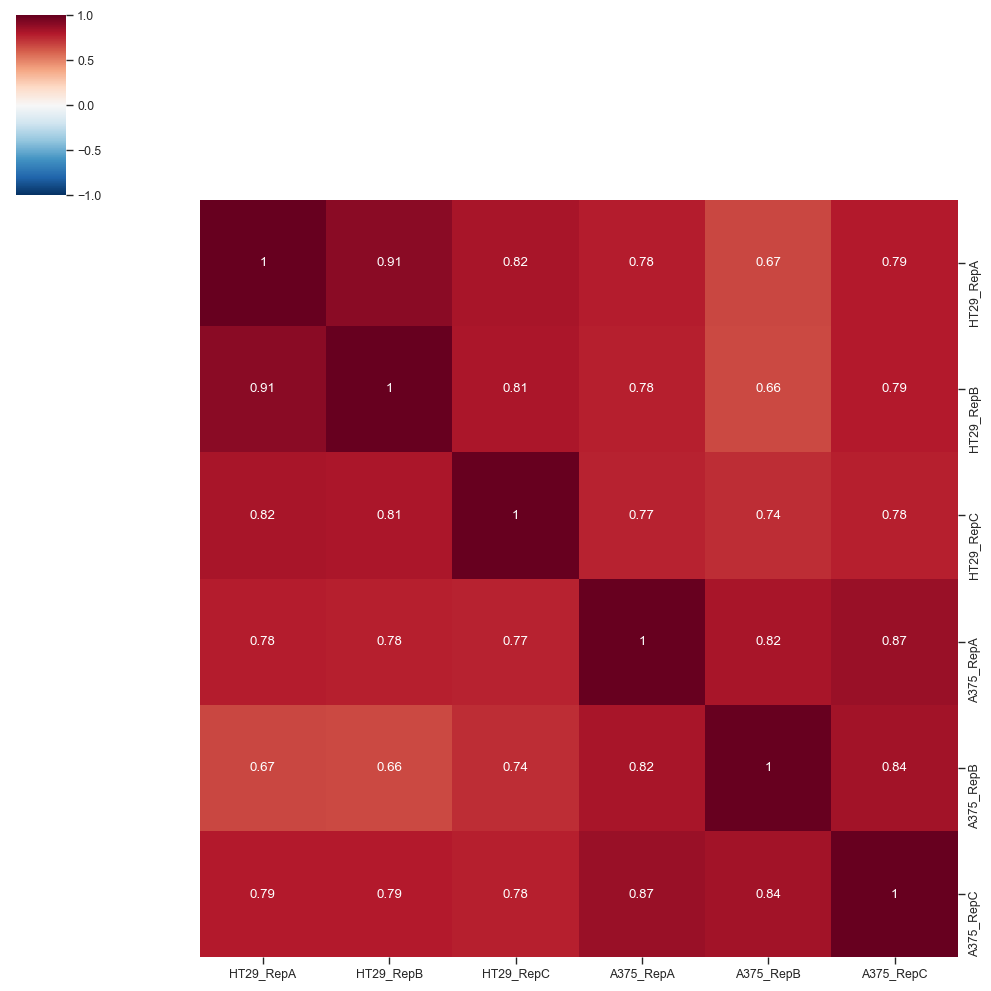

In [60]:
#check replicate correlation
lfc_correlations = lfc_df.corr(numeric_only=True)
sns.clustermap(lfc_correlations, cmap='RdBu_r',
               vmin=-1, vmax=1, annot=True,row_cluster=False,col_cluster=False)

In [61]:
long_lfcs = (lfc_df.melt(id_vars='sgRNA Sequence',
                         var_name='sample', value_name='lfc'))
long_lfcs[['cell_line','rep']] = long_lfcs['sample'].str.split('_',expand=True)
avg_lfcs = (long_lfcs.groupby(['cell_line','sgRNA Sequence'])
            .agg(avg_lfc = ('lfc', 'mean'),
                 n_obs = ('lfc', 'count'))
            .reset_index())

#subset to cell line of interest
avg_lfcs_a375 = avg_lfcs[avg_lfcs['cell_line'] == 'A375']

annotated_sgrna_lfcs = (avg_lfcs_a375.merge(annotations_df,
                                           how='inner',
                                           on='sgRNA Sequence'))
annotated_sgrna_lfcs

,cell_line,sgRNA Sequence,avg_lfc,n_obs,Gene Symbol,Gene ID
0,A375,AAAAAAAAAATACTGAGAGA,0.048424,3,GATA3,2625
1,A375,AAAAAAAAAATTTCCTAGCG,-0.098733,3,POTENTIALLY_ACTIVE_1,POTENTIALLY_ACTIVE_1
2,A375,AAAAAAAAAGCTGTGCGCAG,0.083174,3,MULTIPLE_INTERGENIC_SITES_1,MULTIPLE_INTERGENIC_SITES_1
3,A375,AAAAAAAACTGTCCCGCAAC,0.540755,3,MAP1LC3C,440738
4,A375,AAAAAAAAGAGGAGGGACGG,-1.622465,3,ANKH,56172
...,...,...,...,...,...,...
119667,A375,TTTTGACTCTAATCACCGGT,0.263663,3,NO_SITE_476,NO_SITE_476
119668,A375,TTTTTAATACAAGGTAATCT,0.330629,3,INACTIVE_5T_53,INACTIVE_5T_53
119669,A375,TTTTTAATACAAGGTAATCT,0.330629,3,NO_SITE_477,NO_SITE_477
119670,A375,TTTTTCTCACCCGATGAATC,-0.082754,3,INACTIVE_5T_54,INACTIVE_5T_54


In [62]:
control_sgrna_lfcs = (annotated_sgrna_lfcs[(annotated_sgrna_lfcs['Gene Symbol']
                                            .str.contains('ONE_INTERGENIC'))]
                      .reset_index(drop=True))
control_sgrna_lfcs

,cell_line,sgRNA Sequence,avg_lfc,n_obs,Gene Symbol,Gene ID
0,A375,AAAAACCAGAATATTGTGAT,0.282242,3,ONE_INTERGENIC_SITE_1,ONE_INTERGENIC_SITE_1
1,A375,AAAAAGAAAGCTTGCCAAGG,0.193558,3,ONE_INTERGENIC_SITE_1,ONE_INTERGENIC_SITE_1
2,A375,AAAAAGAATTAAGAGAGACA,-0.034818,3,ONE_INTERGENIC_SITE_2,ONE_INTERGENIC_SITE_2
3,A375,AAAAAGATCAAAGCAAAATT,0.058931,3,ONE_INTERGENIC_SITE_3,ONE_INTERGENIC_SITE_3
4,A375,AAAAAGCATCCAGTGGAGAT,0.008454,3,ONE_INTERGENIC_SITE_2,ONE_INTERGENIC_SITE_2
...,...,...,...,...,...,...
3172,A375,TTTGGTCCAAAGGGGATGGA,-0.707325,3,ONE_INTERGENIC_SITE_1605,ONE_INTERGENIC_SITE_1605
3173,A375,TTTGGTGAGTTTATTCTACT,0.070921,3,ONE_INTERGENIC_SITE_1606,ONE_INTERGENIC_SITE_1606
3174,A375,TTTGTGAAACTATCACACAG,-0.259196,3,ONE_INTERGENIC_SITE_1607,ONE_INTERGENIC_SITE_1607
3175,A375,TTTGTTGACACATGTGGTGC,0.187860,3,ONE_INTERGENIC_SITE_1584,ONE_INTERGENIC_SITE_1584


In [63]:
neg_ctl_mean = np.mean(control_sgrna_lfcs['avg_lfc'])
neg_ctl_sd = np.std(control_sgrna_lfcs['avg_lfc'])
zscored_sgrna_lfcs = annotated_sgrna_lfcs.copy()
zscored_sgrna_lfcs['z_scored_avg_lfc'] = ((zscored_sgrna_lfcs['avg_lfc'] - neg_ctl_mean)/neg_ctl_sd)
zscored_sgrna_lfcs

,cell_line,sgRNA Sequence,avg_lfc,n_obs,Gene Symbol,Gene ID,z_scored_avg_lfc
0,A375,AAAAAAAAAATACTGAGAGA,0.048424,3,GATA3,2625,-0.086202
1,A375,AAAAAAAAAATTTCCTAGCG,-0.098733,3,POTENTIALLY_ACTIVE_1,POTENTIALLY_ACTIVE_1,-0.373318
2,A375,AAAAAAAAAGCTGTGCGCAG,0.083174,3,MULTIPLE_INTERGENIC_SITES_1,MULTIPLE_INTERGENIC_SITES_1,-0.018401
3,A375,AAAAAAAACTGTCCCGCAAC,0.540755,3,MAP1LC3C,440738,0.874380
4,A375,AAAAAAAAGAGGAGGGACGG,-1.622465,3,ANKH,56172,-3.346254
...,...,...,...,...,...,...,...
119667,A375,TTTTGACTCTAATCACCGGT,0.263663,3,NO_SITE_476,NO_SITE_476,0.333750
119668,A375,TTTTTAATACAAGGTAATCT,0.330629,3,INACTIVE_5T_53,INACTIVE_5T_53,0.464407
119669,A375,TTTTTAATACAAGGTAATCT,0.330629,3,NO_SITE_477,NO_SITE_477,0.464407
119670,A375,TTTTTCTCACCCGATGAATC,-0.082754,3,INACTIVE_5T_54,INACTIVE_5T_54,-0.342140


In [64]:
zip_file = ZipFile('../../Data/CRISPickRuns/sgRNA_design_9606_GRCh38_SpyoCas9_CRISPRi_RS3i-Chen2013_Ensembl_20250806.txt.zip')
crispri_genomewide_design = pd.read_table(zip_file.open('sgRNA_design_9606_GRCh38_SpyoCas9_CRISPRi_RS3i-Chen2013_Ensembl_20250806.txt'))
crispri_genomewide_design

/var/folders/mj/lhpd16ys0cx2wkbhm7s0nfcm0000gp/T/ipykernel_10287/689400535.py:2: DtypeWarning: Columns (24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  crispri_genomewide_design = pd.read_table(zip_file.open('sgRNA_design_9606_GRCh38_SpyoCas9_CRISPRi_RS3i-Chen2013_Ensembl_20250806.txt'))


,Input,Quota,Target Taxon,Target Gene ID,Target Gene Symbol,Target Alias,CRISPR Mechanism,Target Domain,Reference Sequence,Strand of Target,...,Seed Score (v1),Off-Target CFD100 Hits,Off-Target Tier I CFD100 Hits,On-Target Ruleset,On-Target Efficacy Score,ATAC-seq Score,On-Target Rank,Pick Order,Picking Round,Picking Notes
0,ENSG00000000003,MAX,9606,ENSG00000000003,TSPAN6,NaN,CRISPRi,"[TSS-50,TSS+300]",NC_000023.11,-,...,0.0,0,0,RS3i-Chen2013,1.7330,0.8571,1,1.0,1.0,NaN
1,ENSG00000000003,MAX,9606,ENSG00000000003,TSPAN6,NaN,CRISPRi,"[TSS-50,TSS+300]",NC_000023.11,-,...,2.0,0,0,RS3i-Chen2013,1.6820,0.8571,2,2.0,1.0,NaN
2,ENSG00000000003,MAX,9606,ENSG00000000003,TSPAN6,NaN,CRISPRi,"[TSS-50,TSS+300]",NC_000023.11,-,...,0.0,0,0,RS3i-Chen2013,1.6170,0.8571,3,3.0,1.0,NaN
3,ENSG00000000003,MAX,9606,ENSG00000000003,TSPAN6,NaN,CRISPRi,"[TSS-50,TSS+300]",NC_000023.11,-,...,0.0,0,0,RS3i-Chen2013,1.5020,0.8571,4,4.0,1.0,NaN
4,ENSG00000000003,MAX,9606,ENSG00000000003,TSPAN6,NaN,CRISPRi,"[TSS-50,TSS+300]",NC_000023.11,-,...,0.0,0,0,RS3i-Chen2013,1.4470,0.8571,5,NaN,NaN,BsmBI:GAGACG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594931,ENSG00000310576,MAX,9606,ENSG00000310576,FAM174C,NaN,CRISPRi,"[TSS-50,TSS+300]",NC_000019.10,+,...,2.0,0,0,RS3i-Chen2013,-0.3301,1.0000,67,52.0,5.0,Previously skipped due to: On-Target Efficacy ...
1594932,ENSG00000310576,MAX,9606,ENSG00000310576,FAM174C,NaN,CRISPRi,"[TSS-50,TSS+300]",NC_000019.10,+,...,1.0,0,0,RS3i-Chen2013,-0.3342,1.0000,68,53.0,5.0,Previously skipped due to: On-Target Efficacy ...
1594933,ENSG00000310576,MAX,9606,ENSG00000310576,FAM174C,NaN,CRISPRi,"[TSS-50,TSS+300]",NC_000019.10,+,...,4.0,0,0,RS3i-Chen2013,-0.3360,1.0000,69,71.0,8.0,Previously skipped due to: On-Target Efficacy ...
1594934,ENSG00000310576,MAX,9606,ENSG00000310576,FAM174C,NaN,CRISPRi,"[TSS-50,TSS+300]",NC_000019.10,+,...,2.0,0,0,RS3i-Chen2013,-0.4603,1.0000,70,54.0,5.0,Previously skipped due to: On-Target Efficacy ...


In [65]:
#merge with genome wide crispick design run to get TSS offset, ATAC-seq overlap
merged_sgrna_design = zscored_sgrna_lfcs.merge(crispri_genomewide_design,
                                                 left_on = 'sgRNA Sequence',
                                                 right_on = 'sgRNA Sequence',
                                                 how = 'inner').reset_index(drop=True)
merged_sgrna_design

,cell_line,sgRNA Sequence,avg_lfc,n_obs,Gene Symbol,Gene ID,z_scored_avg_lfc,Input,Quota,Target Taxon,...,Seed Score (v1),Off-Target CFD100 Hits,Off-Target Tier I CFD100 Hits,On-Target Ruleset,On-Target Efficacy Score,ATAC-seq Score,On-Target Rank,Pick Order,Picking Round,Picking Notes
0,A375,AAAAAAAAAATACTGAGAGA,0.048424,3,GATA3,2625,-0.086202,ENSG00000107485,MAX,9606,...,0.0,0,0,RS3i-Chen2013,0.78110,0.5714,11,9.0,5.0,Previously skipped due to: On-Target Efficacy ...
1,A375,AAAAAAAAAATTTCCTAGCG,-0.098733,3,POTENTIALLY_ACTIVE_1,POTENTIALLY_ACTIVE_1,-0.373318,ENSG00000163104,MAX,9606,...,0.0,0,0,RS3i-Chen2013,-0.14980,1.0000,41,32.0,5.0,Previously skipped due to: On-Target Efficacy ...
2,A375,AAAAAAAACTGTCCCGCAAC,0.540755,3,MAP1LC3C,440738,0.874380,ENSG00000197769,MAX,9606,...,0.0,0,0,RS3i-Chen2013,0.85110,1.0000,13,12.0,5.0,Previously skipped due to: On-Target Efficacy ...
3,A375,AAAAAAAAGAGGAGGGACGG,-1.622465,3,ANKH,56172,-3.346254,ENSG00000154122,MAX,9606,...,4.0,0,0,RS3i-Chen2013,1.17500,1.0000,8,63.0,8.0,Previously skipped due to: On-Target Efficacy ...
4,A375,AAAAAAAAGTGGTGGGGTGG,-0.159739,3,IPO11-LRRC70,101180901,-0.492345,ENSG00000186105,MAX,9606,...,5.0,1,0,RS3i-Chen2013,-0.28920,0.2857,6,9.0,8.0,Previously skipped due to: Off-target CFD100 m...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128139,A375,TTTGTTGTCTATGCCTTTAG,0.451747,3,HABP2,3026,0.700718,ENSG00000148702,MAX,9606,...,0.0,0,0,RS3i-Chen2013,0.09537,0.1429,28,24.0,5.0,Previously skipped due to: On-Target Efficacy ...
128140,A375,TTTGTTTACTTGGCGAGACT,0.127146,3,H2BC1,255626,0.067393,ENSG00000146047,MAX,9606,...,1.0,0,0,RS3i-Chen2013,0.10320,0.1429,27,25.0,5.0,Previously skipped due to: On-Target Efficacy ...
128141,A375,TTTGTTTCAAAGGGCAGAGA,0.575202,3,C1orf116,79098,0.941590,ENSG00000182795,MAX,9606,...,2.0,0,0,RS3i-Chen2013,0.53870,0.7143,27,23.0,5.0,Previously skipped due to: On-Target Efficacy ...
128142,A375,TTTGTTTGCCCGCGTGTGGA,0.095225,3,GALNT7,51809,0.005111,ENSG00000109586,MAX,9606,...,1.0,0,0,RS3i-Chen2013,0.39110,1.0000,38,32.0,5.0,Previously skipped due to: On-Target Efficacy ...


### Format for RS3i Validation

In [66]:
rs3i_input = merged_sgrna_design[['sgRNA Context Sequence','z_scored_avg_lfc','Gene ID','Target Gene Symbol','sgRNA \'Cut\' Site TSS Offset','ATAC-seq Score']].drop_duplicates()
rs3i_input

,sgRNA Context Sequence,z_scored_avg_lfc,Gene ID,Target Gene Symbol,sgRNA 'Cut' Site TSS Offset,ATAC-seq Score
0,AAAAAAAAAAAAAATACTGAGAGAGGGAGA,-0.086202,2625,GATA3,78,0.5714
1,AAATAAAAAAAAAATTTCCTAGCGTGGGGC,-0.373318,POTENTIALLY_ACTIVE_1,SMARCAD1,70,1.0000
2,AAGAAAAAAAAACTGTCCCGCAACCGGGAA,0.874380,440738,MAP1LC3C,40,1.0000
3,CGGGAAAAAAAAGAGGAGGGACGGCGGCGG,-3.346254,56172,ANKH,61,1.0000
4,AAAAAAAAAAAAGTGGTGGGGTGGAGGTCA,-0.492345,101180901,LRRC70,-2,0.2857
...,...,...,...,...,...,...
128139,TTCTTTTGTTGTCTATGCCTTTAGGGGGGA,0.700718,3026,HABP2,6,0.1429
128140,TCTGTTTGTTTACTTGGCGAGACTTGGAGC,0.067393,255626,H2BC1,17,0.1429
128141,CCCTTTTGTTTCAAAGGGCAGAGATGGAGA,0.941590,79098,C1orf116,52,0.7143
128142,TTGTTTTGTTTGCCCGCGTGTGGAGGGAGC,0.005111,51809,GALNT7,215,1.0000


In [67]:
essential_genes = pd.read_csv('../../Data/essentialNonessentialAnnotations/AchillesCommonEssentialControls.csv').Gene
essential_gene_ids = essential_genes.str.split('(',expand=True)[1].str[:-1]
essential_gene_ids

0          14
1          16
2       60496
3          22
4        6059
        ...  
1242    55628
1243    64763
1244    90441
1245    54680
1246    26009
Name: 1, Length: 1247, dtype: object

In [68]:
dolcetto_ess = rs3i_input[rs3i_input['Gene ID'].isin(essential_gene_ids)].reset_index(drop=True)
dolcetto_ess['rs3ChenSeqScore'] = predict_seq(dolcetto_ess['sgRNA Context Sequence'], sequence_tracr='Chen2013')
dolcetto_ess

Calculating sequence-based features


100%|██████████████████████████████████████| 7672/7672 [00:12<00:00, 620.87it/s]


,sgRNA Context Sequence,z_scored_avg_lfc,Gene ID,Target Gene Symbol,sgRNA 'Cut' Site TSS Offset,ATAC-seq Score,rs3ChenSeqScore
0,CTGGAAAAAACCAGGAGTCTGAGGCGGGGG,-3.359142,54443,ANLN,59,1.0,0.072196
1,TACCAAAAAAGACCTGTAGTACCATGGCTG,-2.280999,60496,AASDHPPT,232,1.0,1.028524
2,GAAGAAAAACCAGCAAGAAGGCGGCGGGGG,-3.135844,25896,INTS7,32,1.0,-0.181569
3,TCCGAAAAACCCGCGCTGGTTCACCGGTAG,-3.338995,5693,PSMB5,43,1.0,0.181447
4,GCAGAAAAATGGCAGCCGCCGCTCCGGACT,-3.870085,51018,RRP15,36,1.0,0.032834
...,...,...,...,...,...,...,...
7667,CTCGTTTGGCGCGCGCGCCCTAGGCGGCGG,-3.573586,9631,NUP155,22,1.0,-0.058183
7668,GTGATTTGGCGGCTCCGACTGGCGCGGGAC,-0.945820,3832,KIF11,52,1.0,-0.474364
7669,AACGTTTGGGAGTGTGCAGCTCCTGGGCCC,-3.317097,8467,SMARCA5,53,1.0,-0.030364
7670,GCCCTTTGGGCCGGAGGGTGTCCGCGGATC,0.499993,26973,CHORDC1,234,1.0,-0.339677


In [69]:
#remove overlapping genes
overlapping_genes = pd.read_csv('../../Data/geneOverlap/GW_ensembl_protein_coding_df_1kb.csv')
overlapping_gene_2_3 = overlapping_genes[overlapping_genes['overlap type'].isin([2,3])]
gene_2_3_unique = set(list(overlapping_gene_2_3['Selected Gene name']) +\
list(overlapping_gene_2_3['Overlapping Gene name']))
dolcetto_ess_nonoverlapping = dolcetto_ess[~dolcetto_ess['Target Gene Symbol'].isin(gene_2_3_unique)]
dolcetto_ess_nonoverlapping

,sgRNA Context Sequence,z_scored_avg_lfc,Gene ID,Target Gene Symbol,sgRNA 'Cut' Site TSS Offset,ATAC-seq Score,rs3ChenSeqScore
1,TACCAAAAAAGACCTGTAGTACCATGGCTG,-2.280999,60496,AASDHPPT,232,1.0,1.028524
3,TCCGAAAAACCCGCGCTGGTTCACCGGTAG,-3.338995,5693,PSMB5,43,1.0,0.181447
4,GCAGAAAAATGGCAGCCGCCGCTCCGGACT,-3.870085,51018,RRP15,36,1.0,0.032834
5,GCGGAAAACCAGAGGTGAGGCTAGTGGGAG,-1.982737,4174,MCM5,73,1.0,0.106053
8,AGGTAAAAGAGGGTCTTTGGCAGGCGGAGG,-0.336299,5201,PFDN1,69,1.0,-0.764371
...,...,...,...,...,...,...,...
7664,AGAGTTTGCGTGGCGGGAACGCGGCGGCAG,-2.267423,55164,SHQ1,52,1.0,0.091854
7667,CTCGTTTGGCGCGCGCGCCCTAGGCGGCGG,-3.573586,9631,NUP155,22,1.0,-0.058183
7669,AACGTTTGGGAGTGTGCAGCTCCTGGGCCC,-3.317097,8467,SMARCA5,53,1.0,-0.030364
7670,GCCCTTTGGGCCGGAGGGTGTCCGCGGATC,0.499993,26973,CHORDC1,234,1.0,-0.339677


In [70]:
X_test = dolcetto_ess_nonoverlapping[['Gene ID','sgRNA Context Sequence','sgRNA \'Cut\' Site TSS Offset', 'rs3ChenSeqScore','z_scored_avg_lfc']].copy()
X_test.loc[:,'rs3ChenSeqScore'] = round(X_test['rs3ChenSeqScore'],4)
X_test.loc[:,'sgRNA \'Cut\' Site TSS Offset'] = X_test['sgRNA \'Cut\' Site TSS Offset'].astype(int)
X_test['ATAC_overlap_with_peak'] = pd.cut(dolcetto_ess['ATAC-seq Score'],bins=[0,0.5,1,np.inf],right=False)

# one-hot encoding
X_test_encoded = pd.get_dummies(X_test, columns=['ATAC_overlap_with_peak'])

bool_cols = X_test_encoded.select_dtypes(include=['bool']).columns.tolist()
X_test_encoded[bool_cols] = X_test_encoded[bool_cols].astype(int)

def clean_column_name(name):
    return (
        str(name)
        .replace('[', '_')
        .replace(']', '_')
        .replace('<', '_')
        .replace('>', '_')
        .replace(' ', '_')
        .replace(',', '_')
        .replace('(', '_')
        .replace(')', '_')
    )

X_test_encoded.columns = [clean_column_name(col) for col in X_test_encoded.columns]
X_test_encoded

,Gene_ID,sgRNA_Context_Sequence,sgRNA_'Cut'_Site_TSS_Offset,rs3ChenSeqScore,z_scored_avg_lfc,ATAC_overlap_with_peak__0.0__0.5_,ATAC_overlap_with_peak__0.5__1.0_,ATAC_overlap_with_peak__1.0__inf_
1,60496,TACCAAAAAAGACCTGTAGTACCATGGCTG,232,1.0285,-2.280999,0,0,1
3,5693,TCCGAAAAACCCGCGCTGGTTCACCGGTAG,43,0.1814,-3.338995,0,0,1
4,51018,GCAGAAAAATGGCAGCCGCCGCTCCGGACT,36,0.0328,-3.870085,0,0,1
5,4174,GCGGAAAACCAGAGGTGAGGCTAGTGGGAG,73,0.1061,-1.982737,0,0,1
8,5201,AGGTAAAAGAGGGTCTTTGGCAGGCGGAGG,69,-0.7644,-0.336299,0,0,1
...,...,...,...,...,...,...,...,...
7664,55164,AGAGTTTGCGTGGCGGGAACGCGGCGGCAG,52,0.0919,-2.267423,0,0,1
7667,9631,CTCGTTTGGCGCGCGCGCCCTAGGCGGCGG,22,-0.0582,-3.573586,0,0,1
7669,8467,AACGTTTGGGAGTGTGCAGCTCCTGGGCCC,53,-0.0304,-3.317097,0,0,1
7670,26973,GCCCTTTGGGCCGGAGGGTGTCCGCGGATC,234,-0.3397,0.499993,0,0,1


In [71]:
X_test_encoded.to_csv('../../Data/externalData/dolcetto_rs3i_input.csv',index=False)

### Format for Seed Score Validation

In [72]:
nonessential_genes = pd.read_csv('../../Data/essentialNonessentialAnnotations/AchillesNonessentialControls.csv').Gene
nonessential_gene_ids = nonessential_genes.str.split('(',expand=True)[1].str[:-1]
nonessential_gene_ids

0       64241
1      390110
2       10881
3       10880
4      284382
        ...  
776    219578
777    148066
778      7783
779     57829
780    151112
Name: 1, Length: 781, dtype: object

In [73]:
seed_score_input = merged_sgrna_design[['sgRNA Sequence','sgRNA Context Sequence','z_scored_avg_lfc','Gene ID','Target Gene Symbol']].drop_duplicates()
seed_score_input

,sgRNA Sequence,sgRNA Context Sequence,z_scored_avg_lfc,Gene ID,Target Gene Symbol
0,AAAAAAAAAATACTGAGAGA,AAAAAAAAAAAAAATACTGAGAGAGGGAGA,-0.086202,2625,GATA3
1,AAAAAAAAAATTTCCTAGCG,AAATAAAAAAAAAATTTCCTAGCGTGGGGC,-0.373318,POTENTIALLY_ACTIVE_1,SMARCAD1
2,AAAAAAAACTGTCCCGCAAC,AAGAAAAAAAAACTGTCCCGCAACCGGGAA,0.874380,440738,MAP1LC3C
3,AAAAAAAAGAGGAGGGACGG,CGGGAAAAAAAAGAGGAGGGACGGCGGCGG,-3.346254,56172,ANKH
4,AAAAAAAAGTGGTGGGGTGG,AAAAAAAAAAAAGTGGTGGGGTGGAGGTCA,-0.492345,101180901,LRRC70
...,...,...,...,...,...
128139,TTTGTTGTCTATGCCTTTAG,TTCTTTTGTTGTCTATGCCTTTAGGGGGGA,0.700718,3026,HABP2
128140,TTTGTTTACTTGGCGAGACT,TCTGTTTGTTTACTTGGCGAGACTTGGAGC,0.067393,255626,H2BC1
128141,TTTGTTTCAAAGGGCAGAGA,CCCTTTTGTTTCAAAGGGCAGAGATGGAGA,0.941590,79098,C1orf116
128142,TTTGTTTGCCCGCGTGTGGA,TTGTTTTGTTTGCCCGCGTGTGGAGGGAGC,0.005111,51809,GALNT7


In [74]:
dolcetto_noness = seed_score_input[seed_score_input['Gene ID'].isin(nonessential_gene_ids)].reset_index(drop=True)
dolcetto_noness

,sgRNA Sequence,sgRNA Context Sequence,z_scored_avg_lfc,Gene ID,Target Gene Symbol
0,AAAAAACAACGAACTCCATC,AAAAAAAAAACAACGAACTCCATCTGGGAT,0.313741,54363,HAO1
1,AAAAAAGATCCTCTGAGAGG,ATATAAAAAAGATCCTCTGAGAGGAGGAGG,-0.358502,221833,SP8
2,AAAAACTAGAACATACTTAA,AACAAAAAACTAGAACATACTTAATGGCAA,-0.102615,132724,TMPRSS11B
3,AAAAACTTACCAACCAGAAA,AAAAAAAAACTTACCAACCAGAAAAGGCCC,-0.995554,259239,WFDC11
4,AAAACAAAGGGCAAGGCCAT,CAGTAAAACAAAGGGCAAGGCCATTGGGGA,0.322584,3442,IFNA5
...,...,...,...,...,...
4335,TTTGGCTGTCCACCGAGCTC,TGGATTTGGCTGTCCACCGAGCTCCGGCGC,0.758450,129684,CNTNAP5
4336,TTTGTCCCCTTAATAGGGCT,TAGATTTGTCCCCTTAATAGGGCTGGGTGA,0.940829,388364,TMIGD1
4337,TTTGTCTACTGCACAGGTGA,GCTGTTTGTCTACTGCACAGGTGAGGGAAC,1.749405,7441,VPREB1
4338,TTTGTTGTATAGCTGCAGAT,ATCTTTTGTTGTATAGCTGCAGATTGGATA,0.879778,2554,GABRA1


In [75]:
#remove overlapping genes
overlapping_genes = pd.read_csv('../../Data/geneOverlap/GW_ensembl_protein_coding_df_1kb.csv')
overlapping_gene_2_3 = overlapping_genes[overlapping_genes['overlap type'].isin([2,3])]
gene_2_3_unique = set(list(overlapping_gene_2_3['Selected Gene name']) +\
list(overlapping_gene_2_3['Overlapping Gene name']))
dolcetto_noness_nonoverlapping = dolcetto_noness[~dolcetto_noness['Target Gene Symbol'].isin(gene_2_3_unique)]
dolcetto_noness_nonoverlapping

,sgRNA Sequence,sgRNA Context Sequence,z_scored_avg_lfc,Gene ID,Target Gene Symbol
0,AAAAAACAACGAACTCCATC,AAAAAAAAAACAACGAACTCCATCTGGGAT,0.313741,54363,HAO1
1,AAAAAAGATCCTCTGAGAGG,ATATAAAAAAGATCCTCTGAGAGGAGGAGG,-0.358502,221833,SP8
2,AAAAACTAGAACATACTTAA,AACAAAAAACTAGAACATACTTAATGGCAA,-0.102615,132724,TMPRSS11B
3,AAAAACTTACCAACCAGAAA,AAAAAAAAACTTACCAACCAGAAAAGGCCC,-0.995554,259239,WFDC11
4,AAAACAAAGGGCAAGGCCAT,CAGTAAAACAAAGGGCAAGGCCATTGGGGA,0.322584,3442,IFNA5
...,...,...,...,...,...
4334,TTTGGCACCTCCTCCCAAGC,CCTCTTTGGCACCTCCTCCCAAGCCGGAGT,0.561931,5173,PDYN
4335,TTTGGCTGTCCACCGAGCTC,TGGATTTGGCTGTCCACCGAGCTCCGGCGC,0.758450,129684,CNTNAP5
4336,TTTGTCCCCTTAATAGGGCT,TAGATTTGTCCCCTTAATAGGGCTGGGTGA,0.940829,388364,TMIGD1
4337,TTTGTCTACTGCACAGGTGA,GCTGTTTGTCTACTGCACAGGTGAGGGAAC,1.749405,7441,VPREB1


In [76]:
#remove low RS3 Sequence score guides
dolcetto_noness_nonoverlapping['rs3ChenSeqScore'] = predict_seq(dolcetto_noness_nonoverlapping['sgRNA Context Sequence'], sequence_tracr='Chen2013')
dolcetto_noness_nonoverlapping_active = dolcetto_noness_nonoverlapping[dolcetto_noness_nonoverlapping['rs3ChenSeqScore'] > -0.5].copy()
dolcetto_noness_nonoverlapping_active

Calculating sequence-based features


100%|██████████████████████████████████████| 4212/4212 [00:06<00:00, 637.77it/s]
/var/folders/mj/lhpd16ys0cx2wkbhm7s0nfcm0000gp/T/ipykernel_10287/548321927.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dolcetto_noness_nonoverlapping['rs3ChenSeqScore'] = predict_seq(dolcetto_noness_nonoverlapping['sgRNA Context Sequence'], sequence_tracr='Chen2013')


,sgRNA Sequence,sgRNA Context Sequence,z_scored_avg_lfc,Gene ID,Target Gene Symbol,rs3ChenSeqScore
1,AAAAAAGATCCTCTGAGAGG,ATATAAAAAAGATCCTCTGAGAGGAGGAGG,-0.358502,221833,SP8,0.102364
2,AAAAACTAGAACATACTTAA,AACAAAAAACTAGAACATACTTAATGGCAA,-0.102615,132724,TMPRSS11B,-0.077817
4,AAAACAAAGGGCAAGGCCAT,CAGTAAAACAAAGGGCAAGGCCATTGGGGA,0.322584,3442,IFNA5,-0.348032
7,AAAACCAAGAGCGGGTGACA,AAGGAAAACCAAGAGCGGGTGACAAGGCTG,-0.109509,1618,DAZL,0.266833
8,AAAACCAGAAAAACAATCAT,TTTAAAAACCAGAAAAACAATCATAGGTTT,0.242725,122042,RXFP2,-0.032921
...,...,...,...,...,...,...
4333,TTTGGCAATCTGGGCTGACC,CTGCTTTGGCAATCTGGGCTGACCTGGCTT,0.563234,83417,FCRL4,-0.281126
4334,TTTGGCACCTCCTCCCAAGC,CCTCTTTGGCACCTCCTCCCAAGCCGGAGT,0.561931,5173,PDYN,0.030949
4335,TTTGGCTGTCCACCGAGCTC,TGGATTTGGCTGTCCACCGAGCTCCGGCGC,0.758450,129684,CNTNAP5,0.762615
4337,TTTGTCTACTGCACAGGTGA,GCTGTTTGTCTACTGCACAGGTGAGGGAAC,1.749405,7441,VPREB1,-0.149887


In [77]:
#remove genes that don't behave as nonessential
dolcetto_noness_nonoverlapping_active['gene_avg_zscore'] = dolcetto_noness_nonoverlapping_active.groupby('Gene ID')['z_scored_avg_lfc'].transform('mean')
dolcetto_noness_nonoverlapping_active = dolcetto_noness_nonoverlapping_active[dolcetto_noness_nonoverlapping_active['gene_avg_zscore'] > -2].copy()
dolcetto_noness_nonoverlapping_active

,sgRNA Sequence,sgRNA Context Sequence,z_scored_avg_lfc,Gene ID,Target Gene Symbol,rs3ChenSeqScore,gene_avg_zscore
1,AAAAAAGATCCTCTGAGAGG,ATATAAAAAAGATCCTCTGAGAGGAGGAGG,-0.358502,221833,SP8,0.102364,0.012081
2,AAAAACTAGAACATACTTAA,AACAAAAAACTAGAACATACTTAATGGCAA,-0.102615,132724,TMPRSS11B,-0.077817,0.169592
4,AAAACAAAGGGCAAGGCCAT,CAGTAAAACAAAGGGCAAGGCCATTGGGGA,0.322584,3442,IFNA5,-0.348032,0.178252
7,AAAACCAAGAGCGGGTGACA,AAGGAAAACCAAGAGCGGGTGACAAGGCTG,-0.109509,1618,DAZL,0.266833,-0.416998
8,AAAACCAGAAAAACAATCAT,TTTAAAAACCAGAAAAACAATCATAGGTTT,0.242725,122042,RXFP2,-0.032921,0.229622
...,...,...,...,...,...,...,...
4333,TTTGGCAATCTGGGCTGACC,CTGCTTTGGCAATCTGGGCTGACCTGGCTT,0.563234,83417,FCRL4,-0.281126,-0.125570
4334,TTTGGCACCTCCTCCCAAGC,CCTCTTTGGCACCTCCTCCCAAGCCGGAGT,0.561931,5173,PDYN,0.030949,-0.106527
4335,TTTGGCTGTCCACCGAGCTC,TGGATTTGGCTGTCCACCGAGCTCCGGCGC,0.758450,129684,CNTNAP5,0.762615,-0.032726
4337,TTTGTCTACTGCACAGGTGA,GCTGTTTGTCTACTGCACAGGTGAGGGAAC,1.749405,7441,VPREB1,-0.149887,-0.005390


In [78]:
dolcetto_noness_nonoverlapping_active['promiscuous'] = dolcetto_noness_nonoverlapping_active['z_scored_avg_lfc'] < -3
dolcetto_noness_nonoverlapping_active['nonpromiscuous'] = dolcetto_noness_nonoverlapping_active['z_scored_avg_lfc'] > -1
dolcetto_noness_labeled = dolcetto_noness_nonoverlapping_active[dolcetto_noness_nonoverlapping_active['promiscuous'] | dolcetto_noness_nonoverlapping_active['nonpromiscuous']].copy()
dolcetto_noness_labeled

,sgRNA Sequence,sgRNA Context Sequence,z_scored_avg_lfc,Gene ID,Target Gene Symbol,rs3ChenSeqScore,gene_avg_zscore,promiscuous,nonpromiscuous
1,AAAAAAGATCCTCTGAGAGG,ATATAAAAAAGATCCTCTGAGAGGAGGAGG,-0.358502,221833,SP8,0.102364,0.012081,False,True
2,AAAAACTAGAACATACTTAA,AACAAAAAACTAGAACATACTTAATGGCAA,-0.102615,132724,TMPRSS11B,-0.077817,0.169592,False,True
4,AAAACAAAGGGCAAGGCCAT,CAGTAAAACAAAGGGCAAGGCCATTGGGGA,0.322584,3442,IFNA5,-0.348032,0.178252,False,True
7,AAAACCAAGAGCGGGTGACA,AAGGAAAACCAAGAGCGGGTGACAAGGCTG,-0.109509,1618,DAZL,0.266833,-0.416998,False,True
8,AAAACCAGAAAAACAATCAT,TTTAAAAACCAGAAAAACAATCATAGGTTT,0.242725,122042,RXFP2,-0.032921,0.229622,False,True
...,...,...,...,...,...,...,...,...,...
4333,TTTGGCAATCTGGGCTGACC,CTGCTTTGGCAATCTGGGCTGACCTGGCTT,0.563234,83417,FCRL4,-0.281126,-0.125570,False,True
4334,TTTGGCACCTCCTCCCAAGC,CCTCTTTGGCACCTCCTCCCAAGCCGGAGT,0.561931,5173,PDYN,0.030949,-0.106527,False,True
4335,TTTGGCTGTCCACCGAGCTC,TGGATTTGGCTGTCCACCGAGCTCCGGCGC,0.758450,129684,CNTNAP5,0.762615,-0.032726,False,True
4337,TTTGTCTACTGCACAGGTGA,GCTGTTTGTCTACTGCACAGGTGAGGGAAC,1.749405,7441,VPREB1,-0.149887,-0.005390,False,True


In [79]:
dolcetto_noness_labeled.to_csv('../../Data/externalData/dolcetto_seed_score_validation_input.csv',index=False)

### Gene-Level Analysis

In [80]:
zscored_sgrna_lfcs

,cell_line,sgRNA Sequence,avg_lfc,n_obs,Gene Symbol,Gene ID,z_scored_avg_lfc
0,A375,AAAAAAAAAATACTGAGAGA,0.048424,3,GATA3,2625,-0.086202
1,A375,AAAAAAAAAATTTCCTAGCG,-0.098733,3,POTENTIALLY_ACTIVE_1,POTENTIALLY_ACTIVE_1,-0.373318
2,A375,AAAAAAAAAGCTGTGCGCAG,0.083174,3,MULTIPLE_INTERGENIC_SITES_1,MULTIPLE_INTERGENIC_SITES_1,-0.018401
3,A375,AAAAAAAACTGTCCCGCAAC,0.540755,3,MAP1LC3C,440738,0.874380
4,A375,AAAAAAAAGAGGAGGGACGG,-1.622465,3,ANKH,56172,-3.346254
...,...,...,...,...,...,...,...
119667,A375,TTTTGACTCTAATCACCGGT,0.263663,3,NO_SITE_476,NO_SITE_476,0.333750
119668,A375,TTTTTAATACAAGGTAATCT,0.330629,3,INACTIVE_5T_53,INACTIVE_5T_53,0.464407
119669,A375,TTTTTAATACAAGGTAATCT,0.330629,3,NO_SITE_477,NO_SITE_477,0.464407
119670,A375,TTTTTCTCACCCGATGAATC,-0.082754,3,INACTIVE_5T_54,INACTIVE_5T_54,-0.342140


In [81]:
#create pseudogenes
num_pseudogene = 1000
targeting_sgrna_lfcs = (zscored_sgrna_lfcs.loc[(~zscored_sgrna_lfcs['Gene Symbol']
                                            .str.contains('ONE_INTERGENIC')) &
                                              (~zscored_sgrna_lfcs['Gene Symbol']
                                            .str.contains('NO_SITE')) &
                                            (~zscored_sgrna_lfcs['Gene Symbol']
                                            .str.contains('POTENTIALLY_ACTIVE')) &
                                            (~zscored_sgrna_lfcs['Gene Symbol']
                                            .str.contains('INACTIVE')) &
                                            (~zscored_sgrna_lfcs['Gene Symbol']
                                            .str.contains('MULTIPLE_INTERGENIC')),:].copy()
                      .reset_index(drop=True))
#pseudogenes should include same number of guides as real targets
n_guides = targeting_sgrna_lfcs.groupby('Gene Symbol')['sgRNA Sequence'].nunique().mode()[0]
control_sgrnas = control_sgrna_lfcs['sgRNA Sequence'].unique()
pseudogene_df_list = []

#randomly sample negative controls to create pseudogenes
random.seed(0)
for i in range(num_pseudogene):
     if i%100 == 0:
         print(i)
     chosen_guides = random.choices(control_sgrnas, k=n_guides)
     temp_df_list = []
     for j in range(n_guides):
         g = chosen_guides[j]
         temp_row = zscored_sgrna_lfcs.loc[(zscored_sgrna_lfcs['sgRNA Sequence'] == g) &
                                           (zscored_sgrna_lfcs['Gene Symbol'].str.contains('ONE_INTERGENIC')),:].copy()
         temp_row.loc[:,'sgRNA Sequence'] = g + 'p' + str(i) + 'g' + str(j)
         temp_df_list.append(temp_row)
     temp_df = pd.concat(temp_df_list,ignore_index=True)
     temp_df.loc[:,'Gene Symbol'] = 'Pseudogene_' + str(i)
     pseudogene_df_list.append(temp_df)

pseudogene_df = pd.concat(pseudogene_df_list).reset_index(drop=True)
pseudogene_df

0
100
200
300
400
500
600
700
800
900


,cell_line,sgRNA Sequence,avg_lfc,n_obs,Gene Symbol,Gene ID,z_scored_avg_lfc
0,A375,TCCTACTCTAGAGACCCTTCp0g0,0.580255,3,Pseudogene_0,ONE_INTERGENIC_SITE_1348,0.951449
1,A375,GTGCCTGAATTCATACTGTTp0g1,0.206920,3,Pseudogene_0,ONE_INTERGENIC_SITE_1204,0.223040
2,A375,CGGCATGATGGTGTTAATCAp0g2,0.396057,3,Pseudogene_0,ONE_INTERGENIC_SITE_672,0.592063
3,A375,CAACCACATCGAGGTGGTGGp0g3,0.110895,3,Pseudogene_0,ONE_INTERGENIC_SITE_410,0.035685
4,A375,GAAGCTGGTGGAAGTGTTGGp0g4,-0.077823,3,Pseudogene_0,ONE_INTERGENIC_SITE_814,-0.332520
...,...,...,...,...,...,...,...
5995,A375,GAGTGATAATATAGATGAAGp999g1,0.551727,3,Pseudogene_999,ONE_INTERGENIC_SITE_884,0.895788
5996,A375,AGCCTGGAAAATATCTCCTCp999g2,0.725082,3,Pseudogene_999,ONE_INTERGENIC_SITE_256,1.234019
5997,A375,AGGGGCTGCTGGATGTCGAAp999g3,0.015208,3,Pseudogene_999,ONE_INTERGENIC_SITE_306,-0.151009
5998,A375,CCCACCAGCTAAACGCTCCCp999g4,0.861421,3,Pseudogene_999,ONE_INTERGENIC_SITE_577,1.500030


In [82]:
#redefine zscored_sgrna_lfcs to include both targeting and pseudogene z-scores + annotations
zscored_sgrna_lfcs = pd.concat([targeting_sgrna_lfcs,pseudogene_df]).reset_index(drop=True)
#save sgrna level values
zscored_sgrna_lfcs.to_csv('../../Data/externalData/dolcetto_a375_zscored_sgrna_lfcs.csv', index = False)

In [87]:
#calculate gene-level z-scores using Stouffer's method
zscored_gene_lfcs = (zscored_sgrna_lfcs.groupby(['Gene Symbol'])
                     .agg(z_scored_lfc_sum = ('z_scored_avg_lfc', 'sum'),
                          n_sgrnas = ('avg_lfc', 'count'))
                     .reset_index())
zscored_gene_lfcs['z_scored_avg_lfc'] = (zscored_gene_lfcs['z_scored_lfc_sum']/np.sqrt(zscored_gene_lfcs['n_sgrnas']))
zscored_gene_lfcs = zscored_gene_lfcs.drop('z_scored_lfc_sum', axis=1)

zscored_gene_lfcs

,Gene Symbol,n_sgrnas,z_scored_avg_lfc
0,A1CF,6,0.527877
1,A2M,6,-1.640493
2,A2ML1,6,-0.330339
3,A3GALT2,6,0.792127
4,A4GALT,5,-0.488572
...,...,...,...
19758,ZXDC,6,0.011970
19759,ZYG11A,6,0.059740
19760,ZYG11B,6,0.434266
19761,ZYX,6,-2.836223


In [88]:
#define function to calculate strongest one-sided empirical p-value by calculating area under curve of null distribution of pseudogene z-scores
control_pseudogene_zscores = zscored_gene_lfcs[zscored_gene_lfcs['Gene Symbol'].str.contains('Pseudo')]['z_scored_avg_lfc'].tolist()

def get_empirical_gene_pval(gene_level_z_score):
    kde= scipy.stats.gaussian_kde(control_pseudogene_zscores)
    ha_less=kde.integrate_box_1d(-np.inf, gene_level_z_score)
    ha_greater=kde.integrate_box_1d(gene_level_z_score, np.inf)
    strongest_p_val=np.min([ha_less,ha_greater])
    return ha_less

In [89]:
zscored_gene_lfcs['p_value'] = zscored_gene_lfcs['z_scored_avg_lfc'].apply(get_empirical_gene_pval)
zscored_gene_lfcs['FDR'] = multipletests(zscored_gene_lfcs['p_value'],method='fdr_bh')[1]
zscored_gene_lfcs

,Gene Symbol,n_sgrnas,z_scored_avg_lfc,p_value,FDR
0,A1CF,6,0.527877,0.676245,0.814122
1,A2M,6,-1.640493,0.066948,0.260606
2,A2ML1,6,-0.330339,0.332654,0.625099
3,A3GALT2,6,0.792127,0.773295,0.855345
4,A4GALT,5,-0.488572,0.283373,0.584582
...,...,...,...,...,...
19758,ZXDC,6,0.011970,0.457970,0.707860
19759,ZYG11A,6,0.059740,0.477456,0.717934
19760,ZYG11B,6,0.434266,0.637698,0.796992
19761,ZYX,6,-2.836223,0.009677,0.061158


In [90]:
zscored_gene_lfcs.to_csv('../../Data/externalData/dolcetto_a375_zscored_gene_lfcs.csv', index = False)